In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import ipywidgets as widgets

from ipywidgets import interact, interact_manual
from pprint import pprint
from collections import defaultdict, OrderedDict
from IPython.display import clear_output, display, HTML

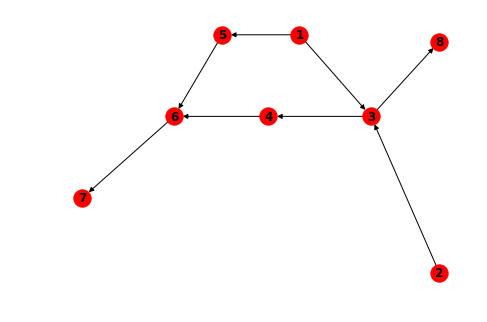

In [11]:
G = nx.DiGraph()
G.add_nodes_from([1, 2, 3, 4, 5, 6, 7, 8])
G.add_edges_from([(1, 3), (2, 3), (3, 8), (3, 4),
                 (5, 6), (4, 6), (6, 7), (1, 5)])
nx.draw(G, with_labels=True, font_weight='bold', 
       pos=nx.spectral_layout(G))

In [12]:
def get_active_trails(graph, node, given_nodes):
    Z = given_nodes[:] # to follow pseudocode convention
    
    # Phase I: Insert all ancestors of Z int V
    L = Z[:] # to avoid deleting from the same list, nodes to be visited
    A = [] # ancestors of Z
    while len(L) > 0:
        Y = L.pop(0)
        if Y not in A:
            L += list(graph.predecessors(Y)) # Y's parents need to be visited
        A.append(Y)  # Y is ancestor of evidence
    
    # Phase II: traverse active trails starting from X (node)
    L = [(node, 'up')] # (Node, direction) to be visited
    V = [] # (Node, direction) marked as visited
    R = [] # Nodes reachable via active trail
    while len(L) > 0:
        (Y, d) = L.pop(0)
        if (Y, d) not in V:
            if Y not in Z:
                R.append(Y) # Y is reachable
            V.append((Y, d)) # Mark (Y, d) as visited
            if d == 'up' and Y not in Z: # Trail up through Y active if Y not in Z
                for Z_light in graph.predecessors(Y):
                    L.append((Z_light, 'up')) # Y's parents to be visited from bottom
                for Z_light in graph.successors(Y):
                    L.append((Z_light, 'down')) # Y's children to be visited from top
            elif d == 'down':
                if Y not in Z:
                    # Downward trails to Y's children are active
                    for Z_light in graph.successors(Y):
                        L.append((Z_light, 'down')) # Y's children to be visited from top
                if Y in A: # v-structure trails are active
                    for Z_light in graph.predecessors(Y):
                        L.append((Z_light, 'up')) # Y's parents to be visited from bottom
    return R

def get_d_separable_pairs(graph, given_nodes):
    data = defaultdict(list)
    pairs = []
    for n1 in graph.nodes():
        for n2 in graph.nodes():
            if n1 == n2 or (n2, n1) in pairs or n1 in given_nodes or n2 in given_nodes:
                continue
            pairs.append((n1, n2))
    for n1, n2 in pairs:
        reachable = get_active_trails(graph, n1, given_nodes)
        data['node 1'].append(n1)
        data['node 2'].append(n2)
        data['d-separated'].append(n2 not in reachable)
    return pd.DataFrame(data=data)

def visualize(graph, given_nodes, node_separation_dataframe):    
    for i, (n1, n2, dseparated) in node_separation_dataframe.iterrows():
        if dseparated:
            plt.figure()
            graph_copy = graph.copy()    
            nodes_color_mapping = OrderedDict()
            for n in graph_copy.nodes:
                nodes_color_mapping[n] = 'red'
            for node in given_nodes:
                nodes_color_mapping[node] = 'gray'
            nodes_color_mapping[n1] = 'blue'
            nodes_color_mapping[n2] = 'blue'

            nx.draw(graph_copy, node_color=list(nodes_color_mapping.values()), with_labels=True, pos=nx.spectral_layout(graph_copy))
        

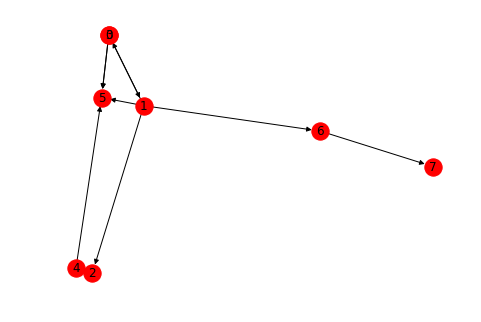

interactive(children=(IntSlider(value=8, description='Number of nodes', min=2), FloatSlider(value=0.4, descrip…

In [13]:
probability = widgets.FloatSlider(
    min=0.1,
    step=0.001,
    max=1,
    value=0.4,
    description="Probability of edge creation",
)
nodes = widgets.IntSlider(
    min=2,
    max=100,
    value=8,
    description="Number of nodes"
)

random_graph = nx.gnp_random_graph(8, 0.4, directed=True)
random_graph = nx.DiGraph([(u, v) for (u, v) in random_graph.edges() if u < v])
nx.draw(random_graph, with_labels=True, pos=nx.spectral_layout(random_graph))

@interact_manual(nodes=nodes, probability=probability)
def generate_graph(nodes, probability):
    global random_graph
    random_graph = nx.gnp_random_graph(nodes, probability, directed=True)
    random_graph = nx.DiGraph([(u, v) for (u, v) in random_graph.edges() if u < v])
    nx.draw(random_graph, with_labels=True, pos=nx.spectral_layout(random_graph))
    

In [16]:
given_nodes = OrderedDict()
for n in random_graph.nodes():
    given_nodes[f'{n}'] = widgets.Checkbox(
        value=False,
        description=f'Is node {n} given?'
    )

@interact(**given_nodes)
def evaluate(**given_nodes):
    real_given_nodes = [int(key) for key in given_nodes.keys() if given_nodes[key]]
    
    pairs = get_d_separable_pairs(random_graph, real_given_nodes)
    visualize(random_graph, real_given_nodes, pairs)
    display(HTML(pairs.to_html()))

interactive(children=(Checkbox(value=False, description='Is node 0 given?'), Checkbox(value=False, description…

http://www.cedar.buffalo.edu/~srihari/CSE674/Chap3/3.4-Reasoning&D-Separation.pdf <- algorithm for activate trail finding (page 26)